In [ ]:
!pip install scanpy gseapy igraph leidenalg scrublet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import gseapy as gp
import networkx as nx


In [ ]:
raw_data = pd.read_csv("/content/gene_raw_data.csv",sep=',',index_col=0)
raw_data.shape

(17551, 384)

In [ ]:
raw_data = raw_data.select_dtypes(include=['number'])
raw_data.shape

(17551, 384)

In [ ]:
raw_data.T

A1BG  A1BG-AS1  A2MP1  AAAS  AACS  AADAC  AAED1  AAGAB  AAK1  \
WMC2659745     0         0      0     0     0      0      0      0     0   
WMC2659746     0         0      0     0     0      0      0      0     0   
WMC2659747     0         0      0     0     1      0      0      0     0   
WMC2659748     0         0      0     0     0      0      0      1     0   
WMC2659749     0         0      0     1     1      0      0      1     0   
...          ...       ...    ...   ...   ...    ...    ...    ...   ...   
WMC2660124     0         0      0     0     2      0      0      0     0   
WMC2660125     1         0      0     0     0      0      0      0     0   
WMC2660126     0         0      0     0     1      0      0      0     0   
WMC2660127     1         0      0     0     0      0      0      1     0   
WMC2660128     1         0      0     0     0      0      0      1     0   

            AAMDC  ...  ZZEF1  ZZZ3  hsa-mir-548d-1  snoR1  snoU109  snoU13  \
WMC2659745      0  ...      0     0               0      0        0       0   
WMC2659746      0  ...      0     0               0      0        0       0   
WMC2659747      0  ...      0     0               0      0        0       0   
WMC2659748      0  ...      0     0               0      0        0       0   
WMC2659749      0  ...      0     1               0      0        0       1   
...           ...  ...    ...   ...             ...    ...      ...     ...   
WMC2660124      0  ...      0     0               0      0        0       0   
WMC2660125      0  ...      0     0               0      0        0       0   
WMC2660126      0  ...      0     0               1      0        0       0   
WMC2660127      0  ...      0     1               0      0        0       0   
WMC2660128      0  ...      1     0               0      0        0       0   

            snoU2-30  snoU2_19  snoZ196  uc_338  
WMC2659745         0         0        0       0  
WMC2659746         0         0        0       0  
WMC2659747         0         1        0       0  
WMC2659748         0         0        0       0  
WMC2659749         0         0        0       1  
...              ...       ...      ...     ...  
WMC2660124         0         0        0       0  
WMC2660125         0         0        0       0  
WMC2660126         0         0        0       0  
WMC2660127         0         0        0       0  
WMC2660128         0         0        0       0  

[384 rows x 17551 columns]

In [ ]:
adata = sc.AnnData(raw_data.T)
adata_copy = sc.AnnData(raw_data.T)

In [ ]:

adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS","RPL"))
adata.var["hb"] = adata.var_names.str.startswith("^HB[^(P)]")

In [ ]:
print(adata.var)

             mt   ribo     hb
A1BG      False  False  False
A1BG-AS1  False  False  False
A2MP1     False  False  False
AAAS      False  False  False
AACS      False  False  False
...         ...    ...    ...
snoU13    False  False  False
snoU2-30  False  False  False
snoU2_19  False  False  False
snoZ196   False  False  False
uc_338    False  False  False

[17551 rows x 3 columns]


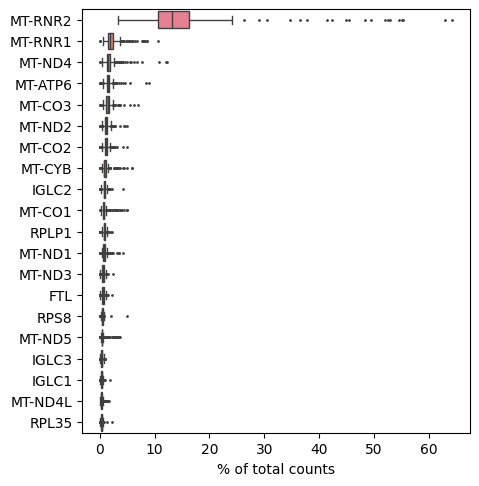

In [ ]:
sc.pl.highest_expr_genes(adata_copy, n_top=20)

In [ ]:
sc.pp.calculate_qc_metrics( adata,qc_vars=["mt","ribo","hb"],inplace=True,log1p=True)

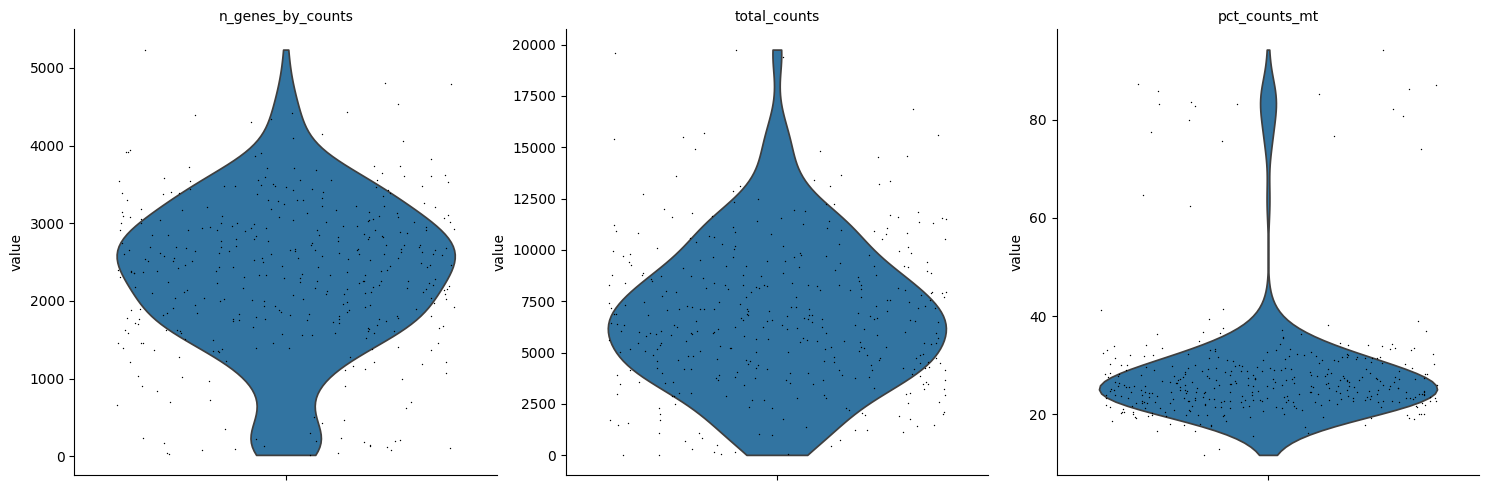

In [ ]:
sc.pl.violin(
      adata,
          ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
              jitter=0.4,
                  multi_panel=True,
                  )


From the violin plot , we can infer that there is a high variablility in gene count and total counts leads to diverse cell populations

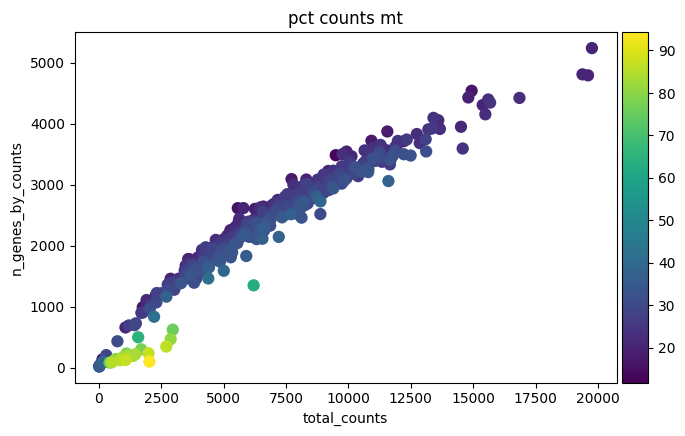

In [ ]:
sc.pl.scatter(adata , "total_counts","n_genes_by_counts",color="pct_counts_mt")

Time to filter the data

In [ ]:
print(f"The cell count before the min_gene_filter: {adata.n_obs}")
sc.pp.filter_cells(adata,min_genes=750)
print(f"The cell count after the min_gene_filter: {adata.n_obs}")

The cell count before the min_gene_filter: 384
The cell count after the min_gene_filter: 354


In [ ]:
print(f"Cell count before pct_count is : {adata.n_obs}")
adata = adata[(adata.obs["pct_counts_mt"] < 40) & (adata.obs["pct_counts_mt"] > 20), :].copy()
print(f"Cell count after pct_count is : {adata.n_obs}")

Cell count before pct_count is : 354
Cell count after pct_count is : 322


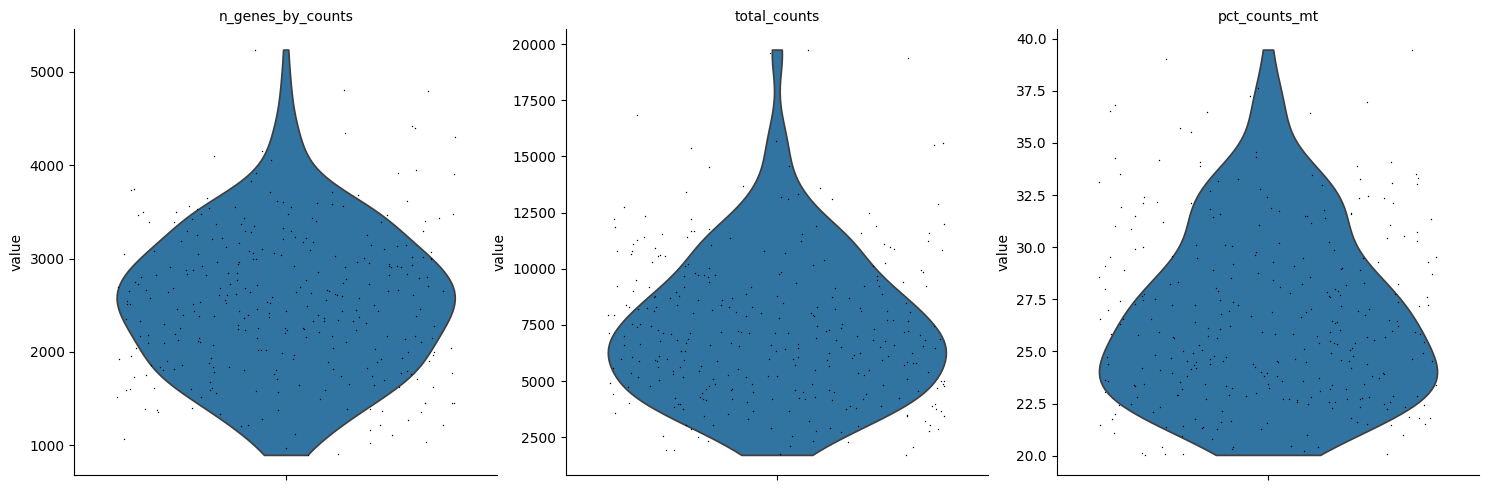

In [ ]:
sc.pl.violin(adata,["n_genes_by_counts","total_counts","pct_counts_mt"],jitter=0.4,multi_panel=True)

# Doublet Deduction
A doublet in single-cell RNA sequencing is a single droplet containing two cells, leading to combined gene expression profiles that can skew analysis.

Doublet refers to the two pure expression combined or mixed together such that We can't find the expression for single gene_expression. This is like Fusing the Apple and Orange together and finding the pure expression of Apple alone

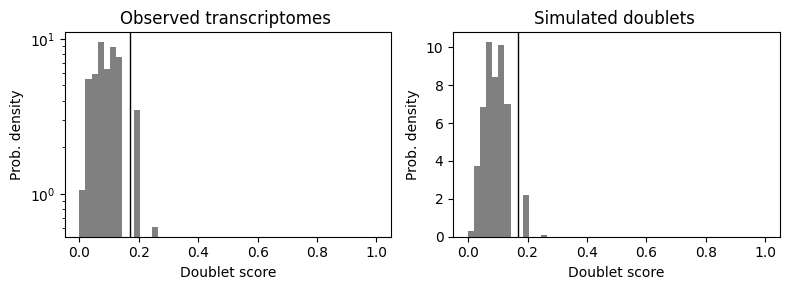

In [ ]:

sc.pp.scrublet(adata, batch_key=None)
sc.pl.scrublet_score_distribution(adata)

In [ ]:
adata.obs['predicted_doublet'].value_counts()

predicted_doublet
False    295
True      27
Name: count, dtype: int64

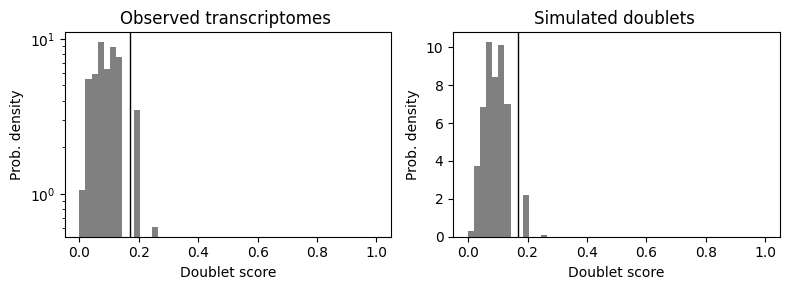

In [ ]:
sc.pl.scrublet_score_distribution(adata)

In [ ]:
adata = adata[~adata.obs["predicted_doublet"]].copy()
print(f"Final number of Singlets for downstream analysis: {adata.n_obs}")

Final number of Singlets for downstream analysis: 295


## Feeling sad for losing the precious data

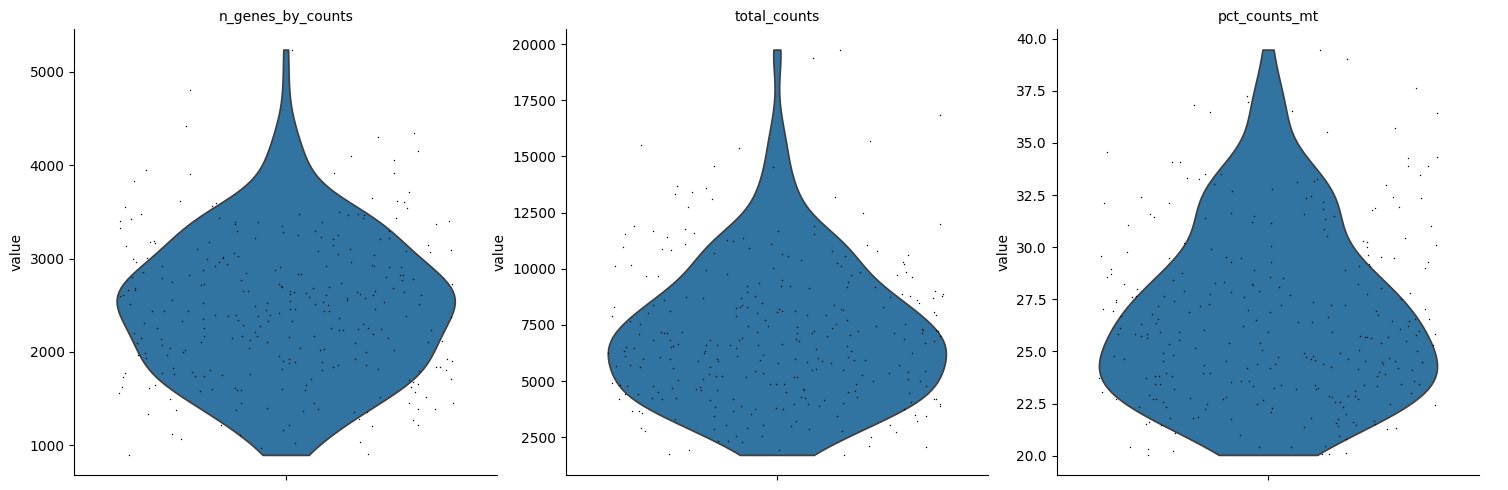

In [ ]:
sc.pl.violin(adata,["n_genes_by_counts","total_counts","pct_counts_mt"],jitter=0.4,multi_panel=True)

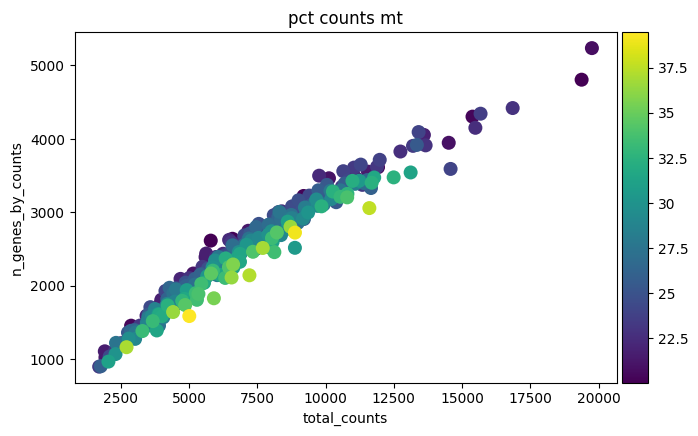

In [ ]:
sc.pl.scatter(adata , "total_counts","n_genes_by_counts",color="pct_counts_mt")

In [ ]:
adata

AnnData object with n_obs × n_vars = 295 × 17551
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'scrublet'

## Time for Normalization

In [ ]:
sc.pp.normalize_total(adata , target_sum=1e4)

1e4 a standard choice in single-cell RNA-seq to represent counts per 10,000 (CP10K).




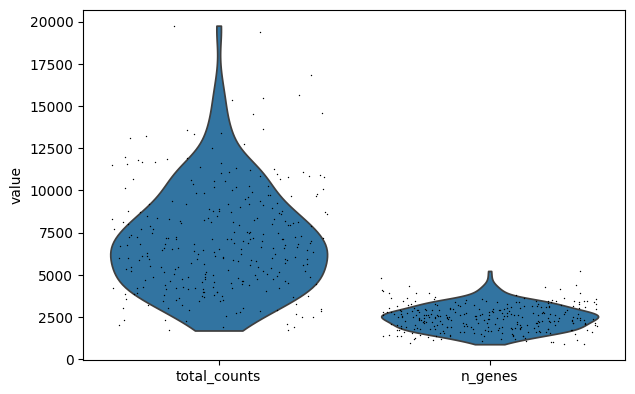

In [ ]:
sc.pl.violin(adata, ['total_counts', 'n_genes'], jitter=0.4)


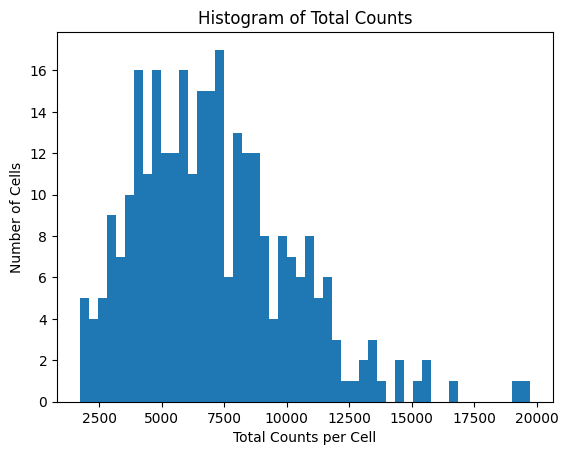

In [ ]:
import matplotlib.pyplot as plt

plt.hist(adata.obs['total_counts'], bins=50)
plt.xlabel('Total Counts per Cell')
plt.ylabel('Number of Cells')
plt.title('Histogram of Total Counts')
plt.show()


In [ ]:
sc.pp.log1p(adata)

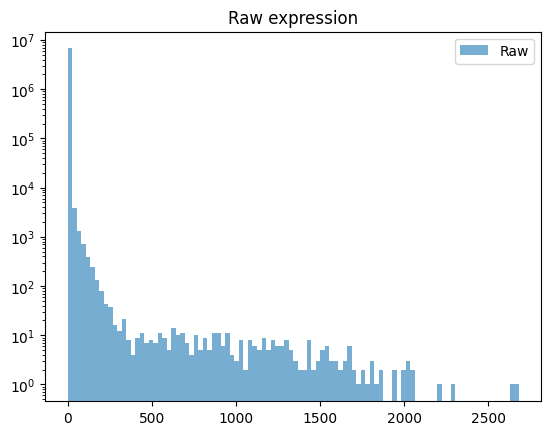

In [ ]:
plt.hist(adata_copy.X.flatten(), bins=100, alpha=0.6, label='Raw')
plt.yscale('log')
plt.legend()
plt.title('Raw expression')
plt.show()

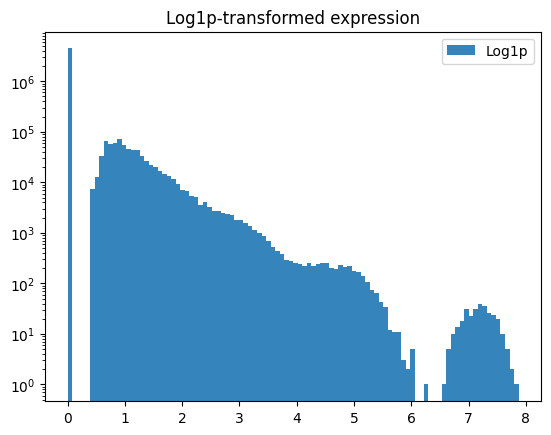

In [ ]:
plt.hist(adata.X.flatten(), bins=100, alpha=0.9, label='Log1p')
plt.yscale('log')
plt.legend()
plt.title('Log1p-transformed expression')
plt.show()

# Feature Selection

since it is a log transformed data , we can go with the seurats implementation [Satija et al., 2015](https://doi.org/10.1016/j.cell.2019.05.031) by keeping the defaults parameters of seurats v2's implementation

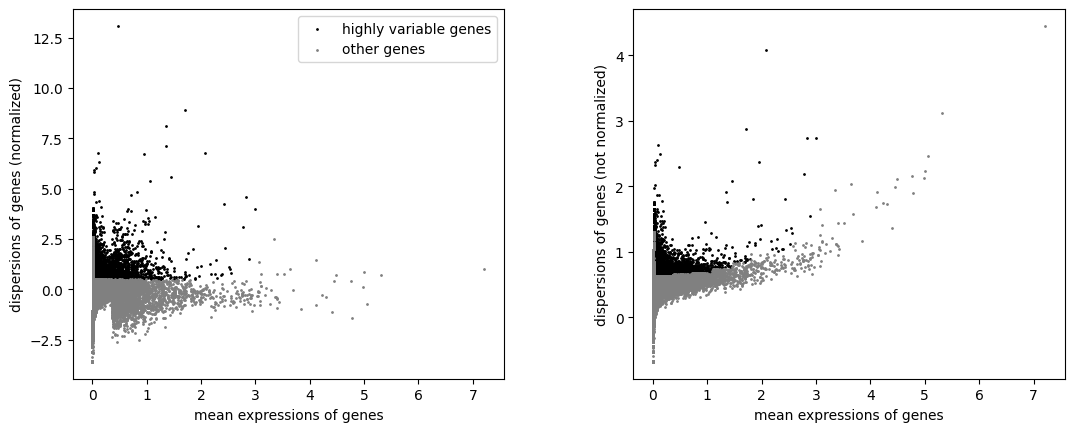

In [ ]:
sc.pp.highly_variable_genes(adata,flavor="seurat",min_mean=0.0125,max_mean=3,min_disp=0.5)
sc.pl.highly_variable_genes(adata)
plt.show()

In [ ]:
adata = adata[:,adata.var.highly_variable].copy()
print(f"The number of highly variable genes: {adata.n_vars}")

The number of highly variable genes: 3669


In [ ]:
adata.obs.columns

Index(['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb',
       'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score',
       'predicted_doublet'],
      dtype='object')

Yeah , It is reduced from 17551 to 3664. But not a big deal , For more info [READ THIS](https://github.com/scverse/scanpy/issues/449?utm_source=chatgpt.com?utm_source=chatgpt.com)

In [ ]:
sc.pp.scale(adata,max_value=10)

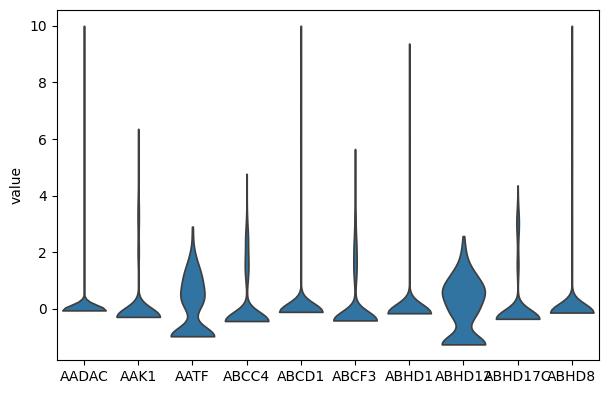

In [ ]:
sc.pl.violin(adata,keys=adata.var_names[:10],stripplot=False)

# Dimension Reduction

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data

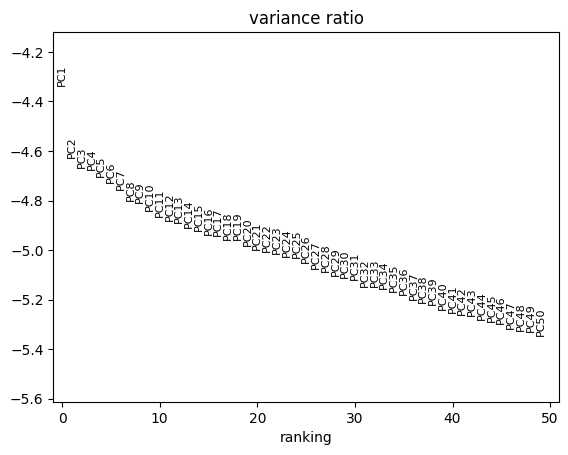

In [ ]:
sc.tl.pca(adata,svd_solver="arpack") #(ARnoldi PACKage) for finding the eigenvalues and vectors effectively
sc.pl.pca_variance_ratio(adata,n_pcs=50,log=True)

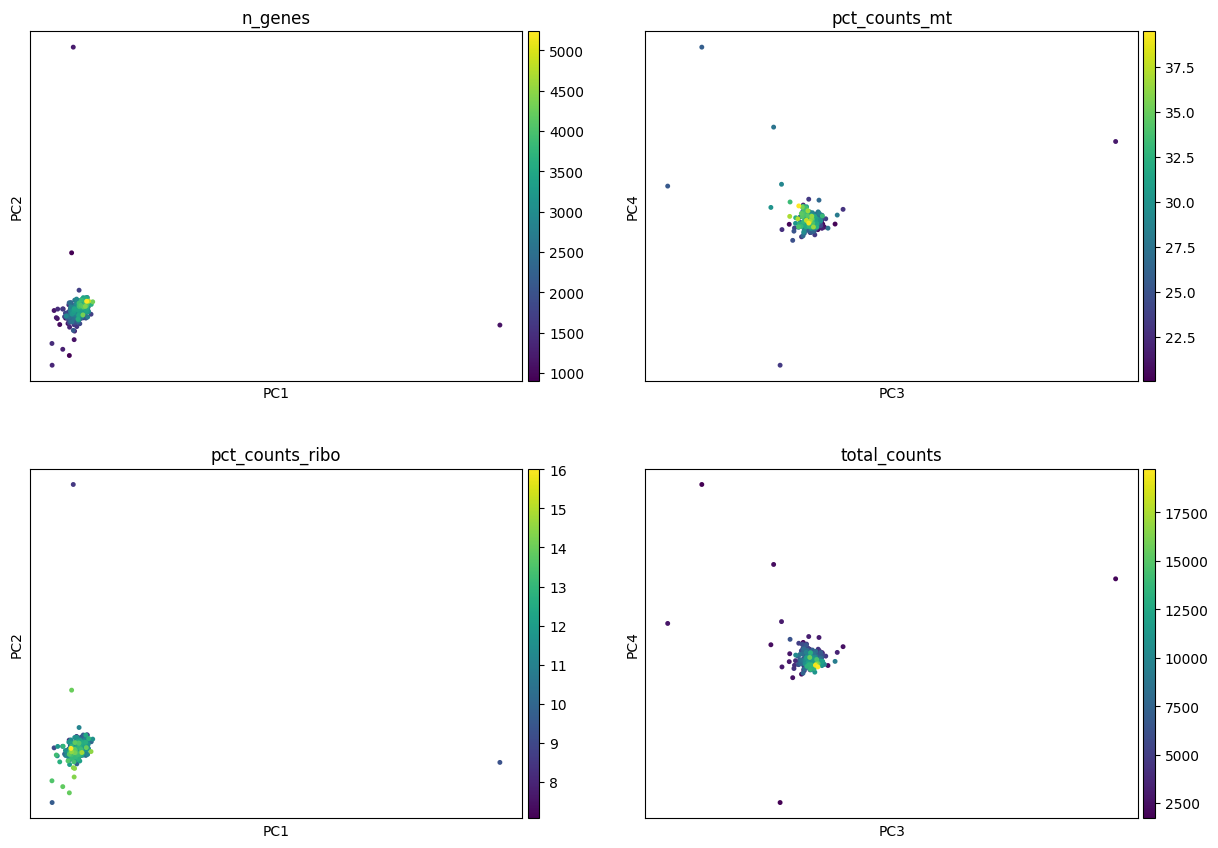

In [ ]:
sc.pl.pca(adata,color=["n_genes","pct_counts_mt","pct_counts_ribo","total_counts"], dimensions=[(0,1),(2,3),(0,1),(2,3)],ncols=2,size=50)

Ok , We use first 4 PCA

In [ ]:
sc.pp.neighbors(adata,n_pcs=4,use_rep='X_pca')

# UMAP & t-SNE
We can use the PCA for visualizing the clusters ,but it is somehow much efficient for visualizing in 2D and in 3D

In [ ]:
adata.obs["PC1"] = adata.obsm["X_pca"][:, 0]
adata.obs["PC2"] = adata.obsm["X_pca"][:, 1]
adata.obs["PC3"] = adata.obsm["X_pca"][:, 2]
adata.obs["PC4"] = adata.obsm["X_pca"][:, 3]

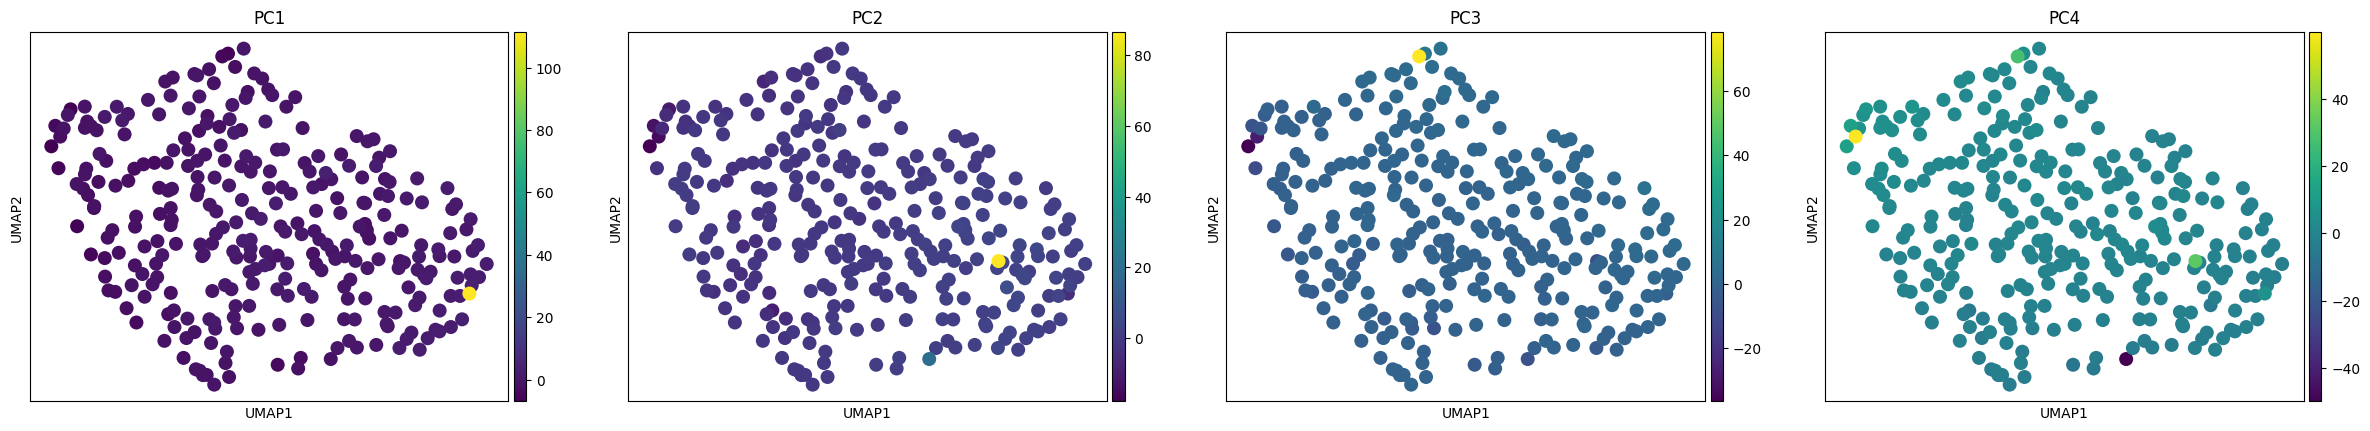

In [ ]:
sc.tl.umap(adata)
sc.pl.umap(adata,color=["PC1","PC2","PC3","PC4"])
plt.show()

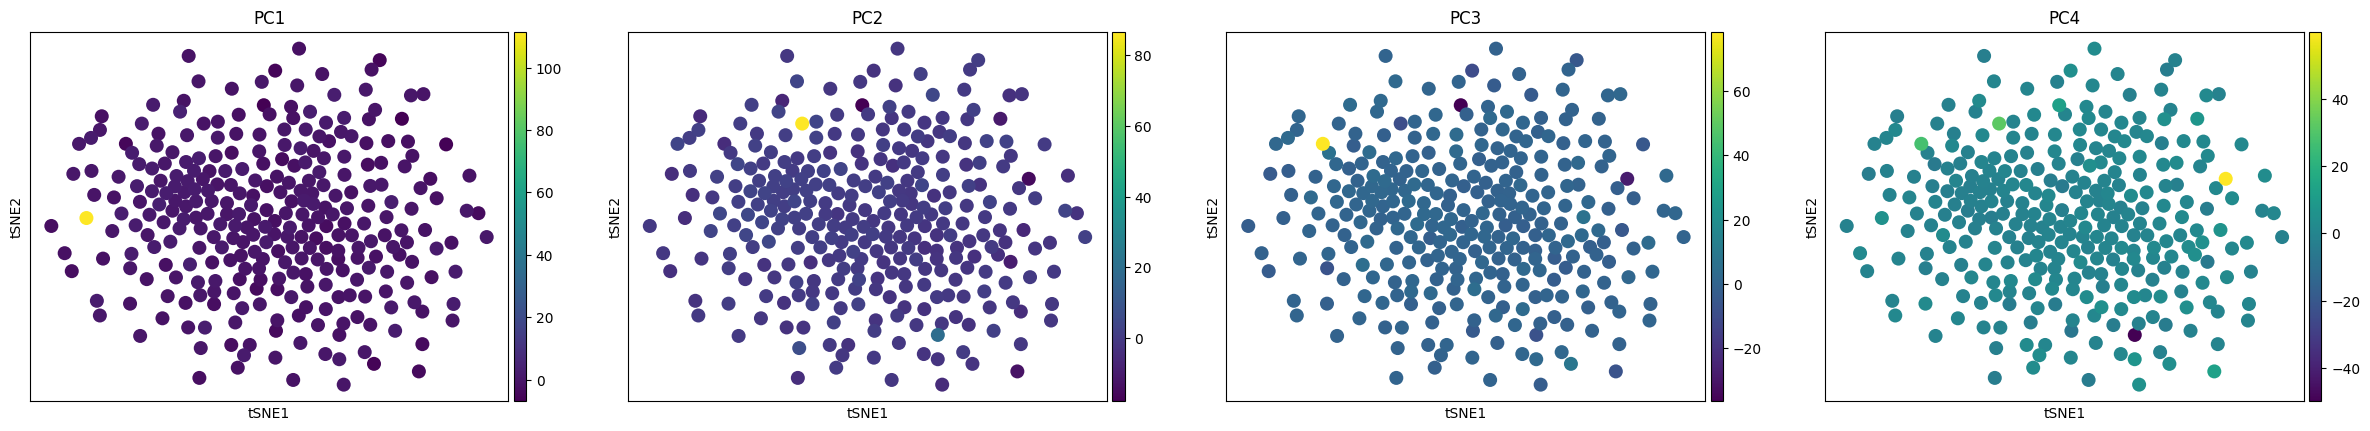

In [ ]:
sc.tl.tsne(adata,use_rep="X_pca")
sc.pl.tsne(adata,color=["PC1","PC2","PC3","PC4"])
plt.show()

Got a confirmation from the Google gemini that "My data has a very strong dominant signal and is relatively "clean" after QC

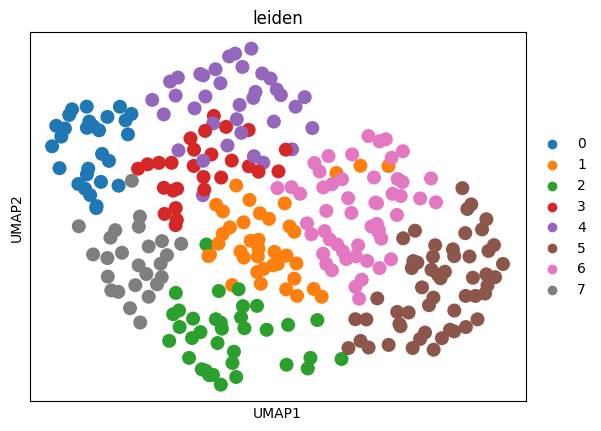

In [ ]:
## Leiden Clustering
adata_s = adata.copy()
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)
sc.pl.umap(adata, color=["leiden"])

In [ ]:
adata.obs.columns

Index(['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb',
       'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score',
       'predicted_doublet', 'PC1', 'PC2', 'PC3', 'PC4', 'leiden'],
      dtype='object')

In [ ]:
adata.X.shape

(295, 3669)

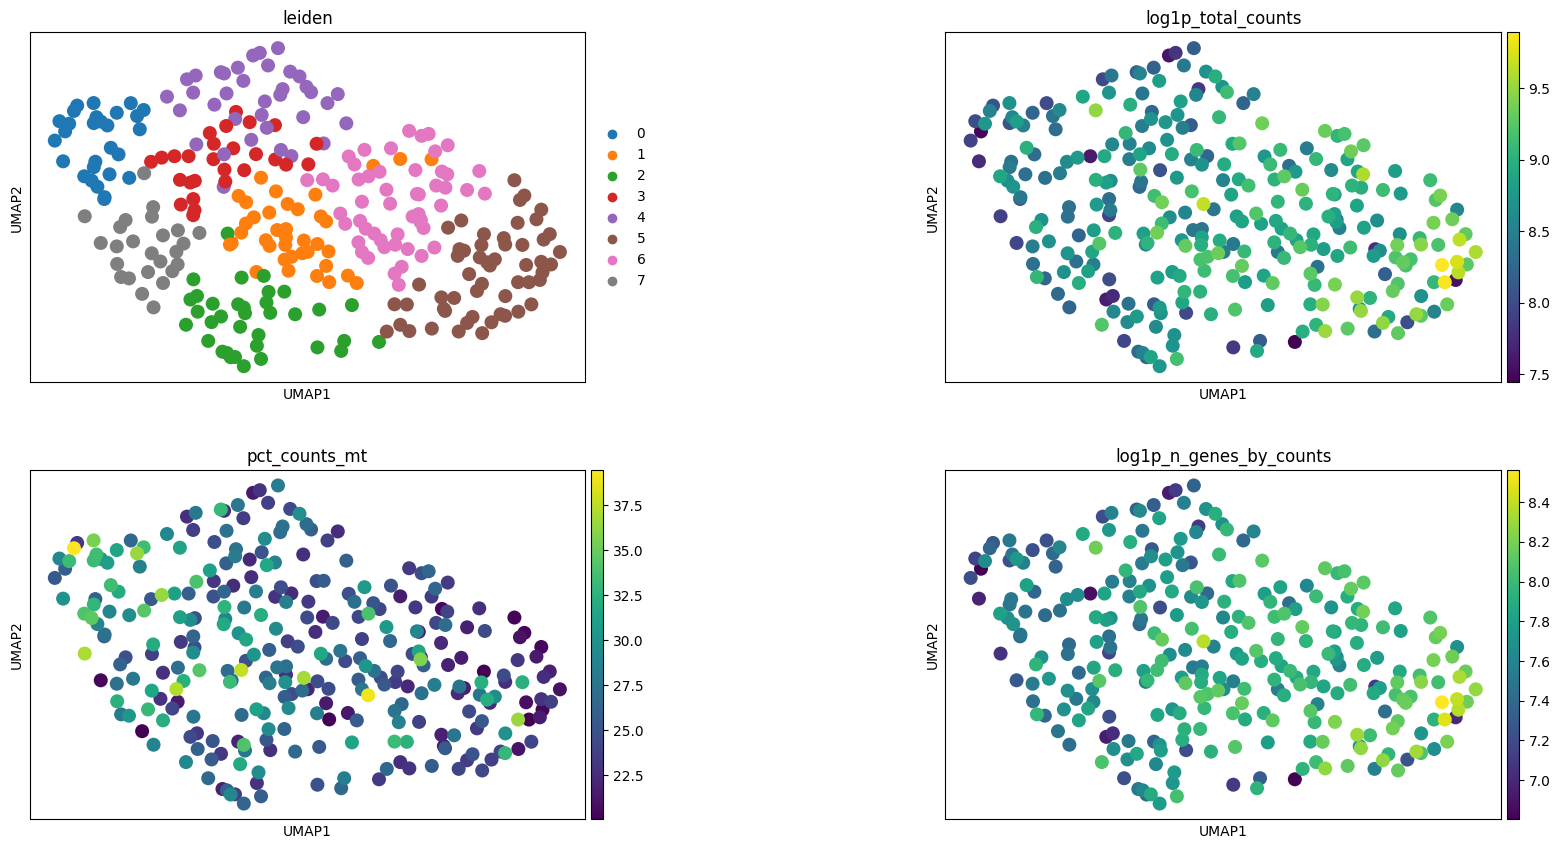

In [ ]:
sc.pl.umap(
      adata,
          color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
              wspace=0.5,
                  ncols=2,
                  )


# Manual cell-type annotation

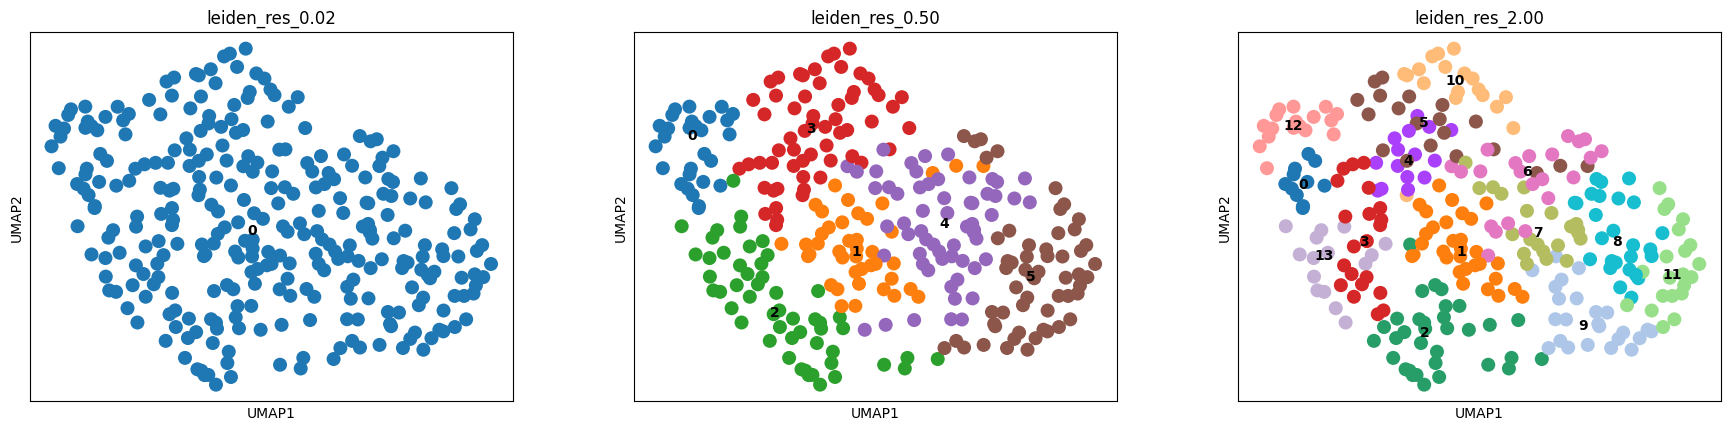

In [ ]:
for res in [0.02,0.5,2.0]:
  sc.tl.leiden(adata,key_added=f"leiden_res_{res:4.2f}",resolution=res,flavor="igraph")


sc.pl.umap(adata,color=["leiden_res_0.02","leiden_res_0.50","leiden_res_2.00"],legend_loc="on data",ncols=3)
plt.show()

Leiden_res_0.20 is not provide any relevant cluster meanwhile leiden_res_2.00 produces more cluster which leads to more heterogenity as well as more complex downstream analysis

In Documentation , They Groups the cluster as the separate gene_expression , I am going to do the same

In [ ]:
print(adata.obs.columns)

Index(['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb',
       'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score',
       'predicted_doublet', 'PC1', 'PC2', 'PC3', 'PC4', 'leiden',
       'leiden_res_0.02', 'leiden_res_0.50', 'leiden_res_2.00'],
      dtype='object')


In [ ]:
## Proceed with the leiden res 0.50

sc.tl.rank_genes_groups(adata,groupby="leiden_res_0.50",method="wilcoxon")




results = adata.uns['rank_genes_groups']
groups = results['names'].dtype.names

print("Raw (unfiltered) top genes for Cluster 0:")
df_raw_cluster0 = pd.DataFrame({
    'names': results['names']['0'],
        'logfoldchanges': results['logfoldchanges']['0'],
            'pvals_adj': results['pvals_adj']['0']
            })
print(df_raw_cluster0.head(20))




Raw (unfiltered) top genes for Cluster 0:
       names  logfoldchanges  pvals_adj
0     LGALS1             NaN   0.117410
1   C12orf57             NaN   0.187349
2      AHNAK             NaN   0.436239
3       SPP1             NaN   0.544917
4      CD8B2             NaN   0.544917
5    WDR83OS             NaN   0.576065
6      LRP10             NaN   0.699615
7       F11R             NaN   0.758026
8       DAD1             NaN   0.981427
9   SH3BGRL3             NaN   0.998414
10      LGMN             NaN   0.998414
11     KRT15             NaN   0.998414
12   CDK2AP1             NaN   0.998414
13     HLA-B             NaN   0.998414
14     PARK7             NaN   0.998414
15    PIEZO2             NaN   0.998414
16   S100A11             NaN   0.998414
17       MVP             NaN   0.998414
18      TOP1             NaN   0.998414
19  HIST1H3H             NaN   0.998414


/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:482: 

In [ ]:
top_genes_per_cluster = {}

for group in groups:
      df = pd.DataFrame({
              'names': results['names'][group],
                      'logfoldchanges': results['logfoldchanges'][group],
                              'pvals_adj': results['pvals_adj'][group]
                                  })
      top_significant_genes = df[(df['pvals_adj'] < 1.01) & (df['logfoldchanges'] > 0.1) # RELAXED THRESHOLD
].head(50)
      top_genes_per_cluster[group] = top_significant_genes
      print(f"Top genes for Cluster {group}:")
      print(top_genes_per_cluster[group])

Top genes for Cluster 0:
            names  logfoldchanges  pvals_adj
1217    UNC5B-AS1        1.475366   0.998414
1218   AL355339.1        1.475366   0.998414
1219       PDE11A        1.475366   0.998414
1220      PLA2G4C        1.475366   0.998414
1221   AC006330.1        1.475366   0.998414
1222       FCGR2A        1.475366   0.998414
1223   AC003986.3        1.475366   0.998414
1224      NAPEPLD        1.475366   0.998414
1225   AL357054.4        1.475366   0.998414
1226   AL356317.1        1.475366   0.998414
1227      RPS4XP9        1.475366   0.998414
1228   AC097637.2        1.475366   0.998414
1229   AC100788.2        1.475366   0.998414
1230   AC109635.3        1.475366   0.998414
1231      MIR6803        1.475366   0.998414
1232   AC117382.2        1.475366   0.998414
1233   AL022326.1        1.475366   0.998414
1234   AC097534.1        1.475366   0.998414
1235   AL031963.3        1.475366   0.998414
1236          TAT        1.475366   0.998414
1237   AC020551.1        1.475

In [ ]:
df

names  logfoldchanges  pvals_adj
0        CDC20             NaN   0.000001
1        KPNA2             NaN   0.000001
2       TUBA1C             NaN   0.000004
3         PLK1             NaN   0.000006
4       TUBA1B             NaN   0.000010
...        ...             ...        ...
3664    S100A6             NaN   0.469598
3665    TMSB4X             NaN   0.468974
3666  HIST1H1E             NaN   0.291674
3667    LGALS1             NaN   0.193039
3668       CD9             NaN   0.099227

[3669 rows x 3 columns]

In [ ]:
for cluster_id , gene_df in top_genes_per_cluster.items():
  if not gene_df.empty:
    gene_names = gene_df["names"].tolist()

    gene_string = ", ".join(gene_names)

    print(f"Cluster {cluster_id}: {gene_string}")

Cluster 0: UNC5B-AS1, AL355339.1, PDE11A, PLA2G4C, AC006330.1, FCGR2A, AC003986.3, NAPEPLD, AL357054.4, AL356317.1, RPS4XP9, AC097637.2, AC100788.2, AC109635.3, MIR6803, AC117382.2, AL022326.1, AC097534.1, AL031963.3, TAT, AC020551.1, AC022826.2, ATP1A1-AS1, SPATA31A1, CEP83-AS1, RUSC1-AS1, CHRD, AP000350.4, AP000893.1, AP001999.1, MIR646HG, AC064805.2, RPS26P6, Z69890.1, RPSAP26, TCEA3, CMTM1, AC092902.2, AC084880.1, ZBTB8OSP2, C9orf85, NME8, SERPING1, CAPS, NIFKP3, HS3ST2, C8orf58, AC010654.1, MACROD2-AS1, FBLIM1
Cluster 1: AC124045.1, ZNF841, C19orf38, TLR7, SNRPGP10, SDHAP1, SNRPEP4, LINC01715, ATP8A2, EVI5L, FBXO4, RFX3, NTRK3, FAM24B, C2orf76, CREBRF, DHFR2, CENPV, AC008763.2, AL355339.1, NAPEPLD, AL133410.1, RNU6-650P, AC010654.1, ATP1A1-AS1, AK7, AC003986.3, AL031963.3, AL022326.1, AL357054.4, AL356317.1, AP000552.2, AC109635.3, AP000893.1, PLA2G4C, AC006330.1, RPSAP26, AC117382.2, SNAI3-AS1, ZNF565, MIR646HG, LINC01623, Z69890.1, MIR6803, AADAC, RUSC1-AS1, AP000350.4, AC142086

In the previous experiment , I tried to find the similarity between those genes and Tries to apply the Manual name but ends in confusion

In [ ]:

# sc.tl.rank_genes_groups(adata, groupby='leiden_res_0.50', method='wilcoxon')

results = adata.uns['rank_genes_groups']
groups = results['names'].dtype.names


top_20_genes_per_cluster_names = {}

for group in groups:

        df = pd.DataFrame({
                'names': results['names'][group],
                        'logfoldchanges': results['logfoldchanges'][group],
                                'pvals_adj': results['pvals_adj'][group]
                                    })


        df_upregulated = df[df['logfoldchanges'] > 0].sort_values(by='logfoldchanges', ascending=False)

        top_20_names = df_upregulated['names'].head(20).tolist()

        top_20_genes_per_cluster_names[group] = top_20_names


for cluster_id, gene_names_list in top_20_genes_per_cluster_names.items():
  if gene_names_list: # Check if the list is not empty
      genes_string = ", ".join(gene_names_list)
      print(f"Cluster {cluster_id}: {genes_string}")
  else:
      print(f"Cluster {cluster_id}: No upregulated genes found.")

Cluster 0: RNU6-481P, TBC1D17, GPR153, CCDC144B, MIR4712, TPGS1, AC084824.4, LINC01176, MIR31HG, FTH1P16, PCDH11Y, C14orf79, AL138785.1, SNORA74B, AL590399.4, AL136537.2, BNIP3P1, ISCA1P6, MINDY3, AC092718.3
Cluster 1: NFKBID, DNAJC27-AS1, PAGE5, AL513175.2, AC079848.1, AL606834.2, AC233702.1, HRAT92, LGALS3BP, B4GALNT4, RFX3, ZNF671, LINC01194, LINC01547, GSDMB, AC026124.2, LINC01317, RPS26P15, KCTD15, AC124283.1
Cluster 2: ABRAXAS1, RPS10P5, TIMD4, PSTK, NPM1P50, NOD2, Z97192.2, ATG16L2, GCK, UBE2D3P2, AP000786.1, AP002770.1, ZKSCAN3, AC062017.1, CISD1P1, AC021106.1, UPF3AP2, AC023283.1, AL450326.1, AL355001.2
Cluster 3: RPS29P16, ADAMTS20, CNTN5, RNU6-703P, TSPAN9, RAD21-AS1, AC092645.1, AC010894.2, ZNF558, AC034102.5, SGK1, RPSAP3, PLEKHM1P1, AL121992.3, RNA5SP395, AC010326.2, AC027682.6, SSSCA1-AS1, CARD18, LINC01277
Cluster 4: AC090579.1, TSPAN9, LINC01572, AC092645.1, RBM26-AS1, SEPT7P2, FCHSD1, UNC13D, AC091564.2, SGK1, ADA2, PLEKHM1P1, AL121992.3, AL109811.1, SH3GL3, RNA5SP395

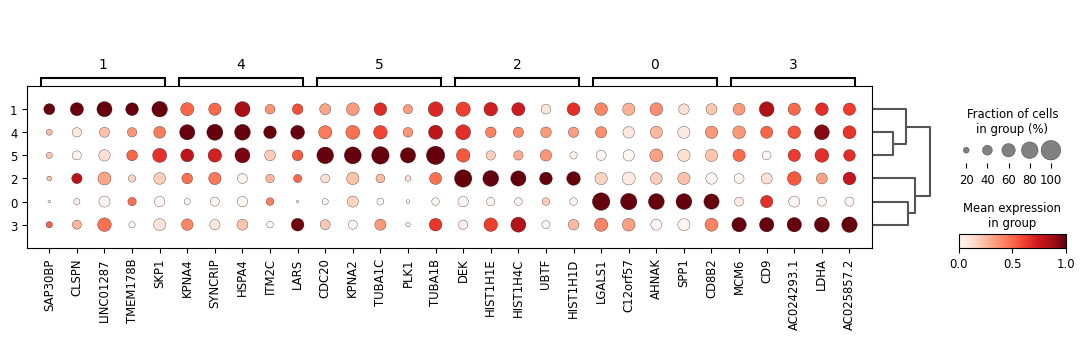

In [ ]:
sc.pl.rank_genes_groups_dotplot(
      adata, groupby="leiden_res_0.50", standard_scale="var", n_genes=5
      )


In [ ]:
'PPIA' in adata_copy.raw.var_names if adata_copy.raw is not None else 'PPIA' in adata_copy.var_names


True

## Naming the Cluster based upon the dotplot

New 'annotated_clusters' column added to adata.obs:
annotated_clusters
PLK1+ Proliferative Myeloma Cluster        59
LDHA+ Glycolytic Proliferative Cluster     59
KPNA2+ Stress-Proliferative Cluster        56
Histone-Dense Proliferative Cluster        52
Checkpoint-Activated Cell Cycle Cluster    41
MIR31HG+ Regulatory Plasma-like Cluster    28
Name: count, dtype: int64
categories: MIR31HG+ Regulatory Plasma-like Cluster, Checkpoint-Activated Cell Cycle Cluster, Histone-Dense Proliferative Cluster, etc.
var_group_labels: 0, 1, 2, etc.


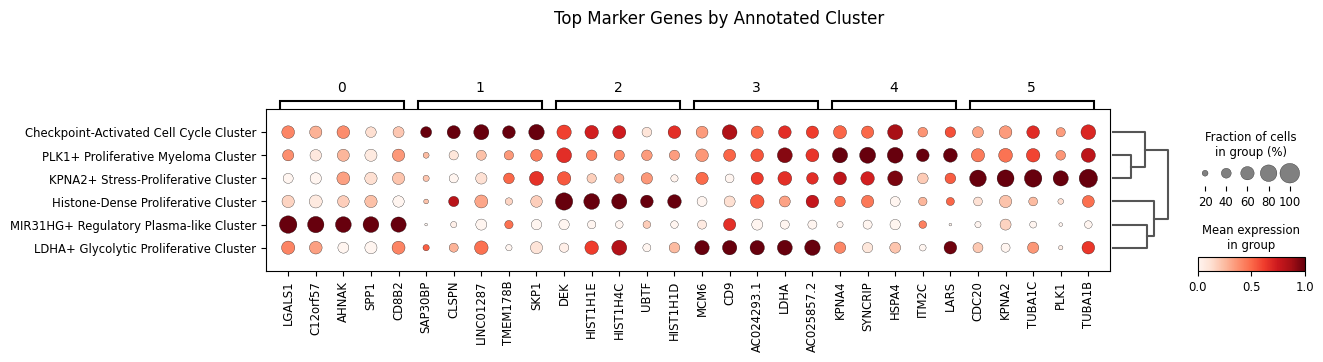

In [ ]:
cluster_name_mapping = {
    '0': 'MIR31HG+ Regulatory Plasma-like Cluster',
    '1': 'Checkpoint-Activated Cell Cycle Cluster',
    '2': 'Histone-Dense Proliferative Cluster',
    '3': 'LDHA+ Glycolytic Proliferative Cluster',
    '4': 'PLK1+ Proliferative Myeloma Cluster',
    '5': 'KPNA2+ Stress-Proliferative Cluster',

}

adata.obs["annotated_clusters"] = adata.obs["leiden_res_0.50"].map(cluster_name_mapping).astype("category")


print("New 'annotated_clusters' column added to adata.obs:")
print(adata.obs['annotated_clusters'].value_counts())

sc.pl.rank_genes_groups_dotplot(
      adata,
          groupby="annotated_clusters",
          standard_scale="var",
          n_genes=5,
          title="Top Marker Genes by Annotated Cluster" # Add a descriptive title for clarity
)
plt.show()




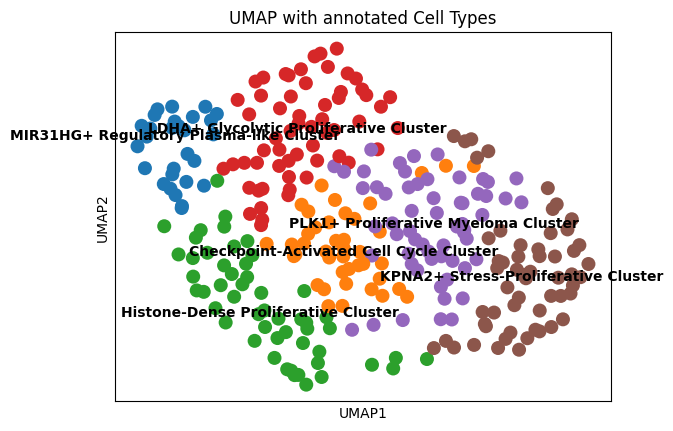

In [ ]:
sc.pl.umap(adata , color="annotated_clusters",legend_loc="on data",title="UMAP with annotated Cell Types")
plt.show()

In [ ]:
sc.get.rank_genes_groups_df(adata, group="5").head(5)

names    scores  logfoldchanges         pvals  pvals_adj
0   CDC20  6.258518             NaN  3.886537e-10   0.000001
1   KPNA2  6.151483             NaN  7.676202e-10   0.000001
2  TUBA1C  5.906955             NaN  3.484895e-09   0.000004
3    PLK1  5.811232             NaN  6.201471e-09   0.000006
4  TUBA1B  5.670259             NaN  1.425819e-08   0.000010

In [ ]:

df_cluster_0 = sc.get.rank_genes_groups_df(adata, group="0").head(5)
print("Top 5 genes for original Cluster 0:")
print(df_cluster_0)


df_cluster_1 = sc.get.rank_genes_groups_df(adata, group="1").head(5)
print("\nTop 5 genes for original Cluster 1:")
print(df_cluster_1)

Top 5 genes for original Cluster 0:
      names    scores  logfoldchanges     pvals  pvals_adj
0    LGALS1  3.474393             NaN  0.000512   0.117410
1  C12orf57  3.288099             NaN  0.001009   0.187349
2     AHNAK  2.903866             NaN  0.003686   0.436239
3      SPP1  2.708257             NaN  0.006764   0.544917
4     CD8B2  2.698942             NaN  0.006956   0.544917

Top 5 genes for original Cluster 1:
       names    scores  logfoldchanges     pvals  pvals_adj
0    SAP30BP  2.780014             NaN  0.005436        1.0
1      CLSPN  2.717863             NaN  0.006571        1.0
2  LINC01287  2.566926             NaN  0.010260        1.0
3   TMEM178B  2.497869             NaN  0.012494        1.0
4       SKP1  2.473206             NaN  0.013391        1.0


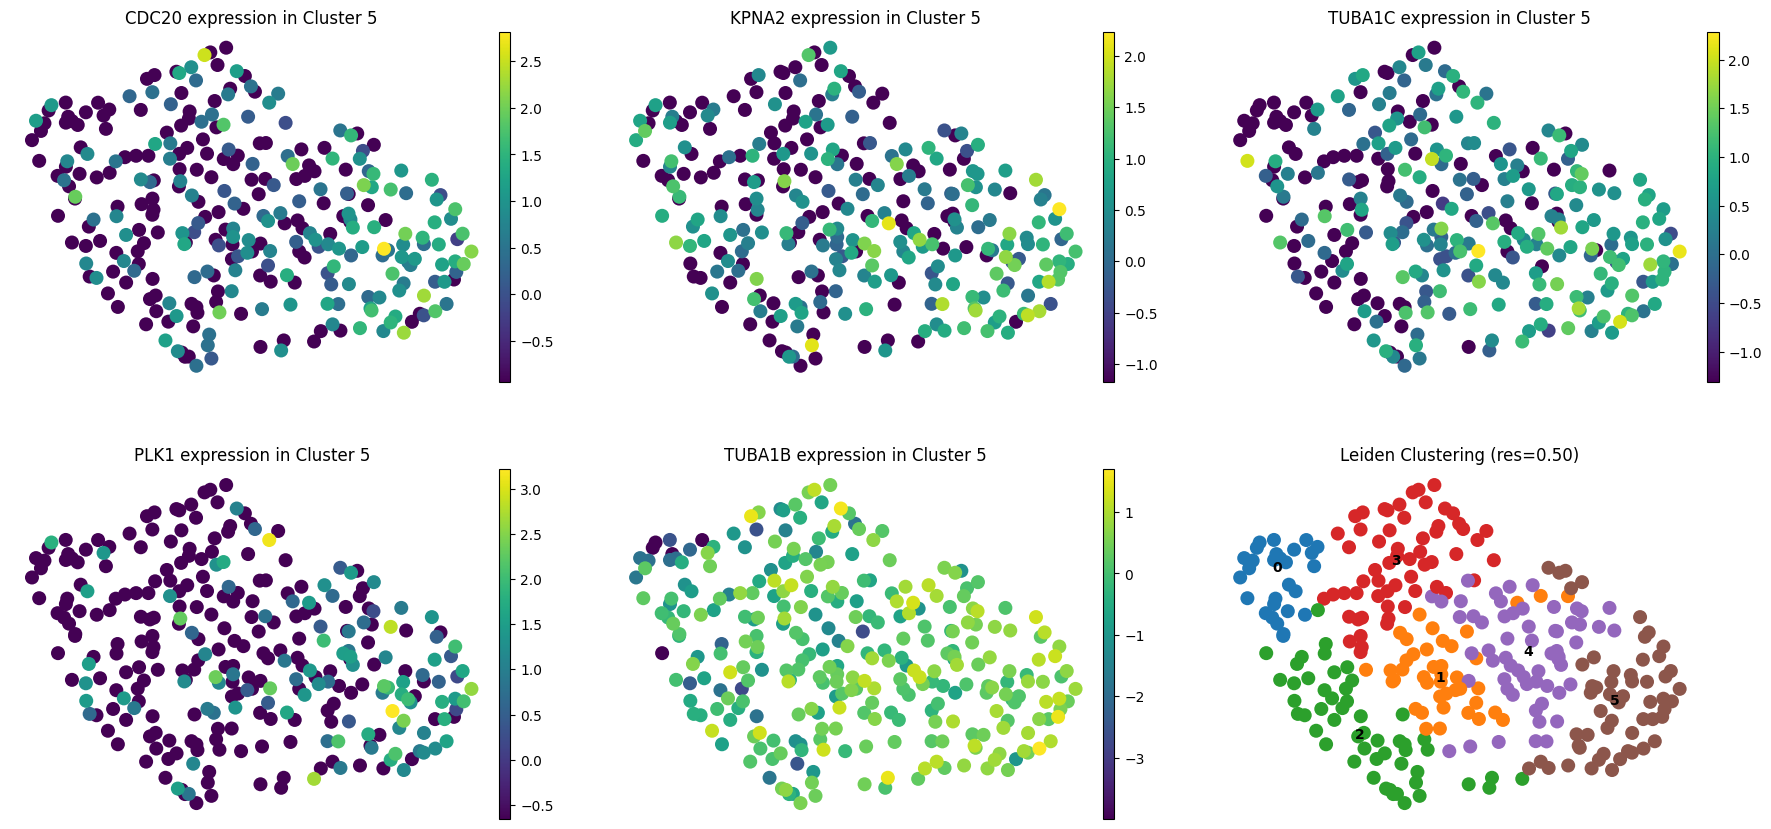

In [ ]:
dc_cluster_genes = sc.get.rank_genes_groups_df(adata, group="5").head(5)["names"]
sc.pl.umap(
      adata,
          color=[*dc_cluster_genes, "leiden_res_0.50"],
              legend_loc="on data",
                  frameon=False,
                      ncols=3,
                          title=[f'{gene} expression in Cluster 5' for gene in dc_cluster_genes] + ['Leiden Clustering (res=0.50)'] # Add titles
                          )
plt.show()


In [ ]:
malignant_cluster_ids =['0','1','2','3','4','5']
gene_list_for_gsea =[]

for cluster_id in malignant_cluster_ids:
      if cluster_id in top_20_genes_per_cluster_names:
        gene_list_for_gsea.extend(top_20_genes_per_cluster_names[cluster_id])
      else:
        print(f"Warning: Numerical cluster ID '{cluster_id}' not found in top_20_genes_per_cluster_names.")


gene_list_for_gsea = list(set(gene_list_for_gsea))
print(f"\nTotal unique top 20 genes (from selected malignant clusters) for GSEA: {len(gene_list_for_gsea)}")


Total unique top 20 genes (from selected malignant clusters) for GSEA: 103


In [ ]:
top_variable_genes = adata.var[adata.var["highly_variable"]].index.tolist()
len(top_variable_genes)

3669

In [ ]:
gp.get_library_name()

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'COMPARTMENTS_Curated_2025',
 'COMPARTMENTS_Experimental_2025',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Scre


Running GSEA for MSigDB_Hallmark_2020...


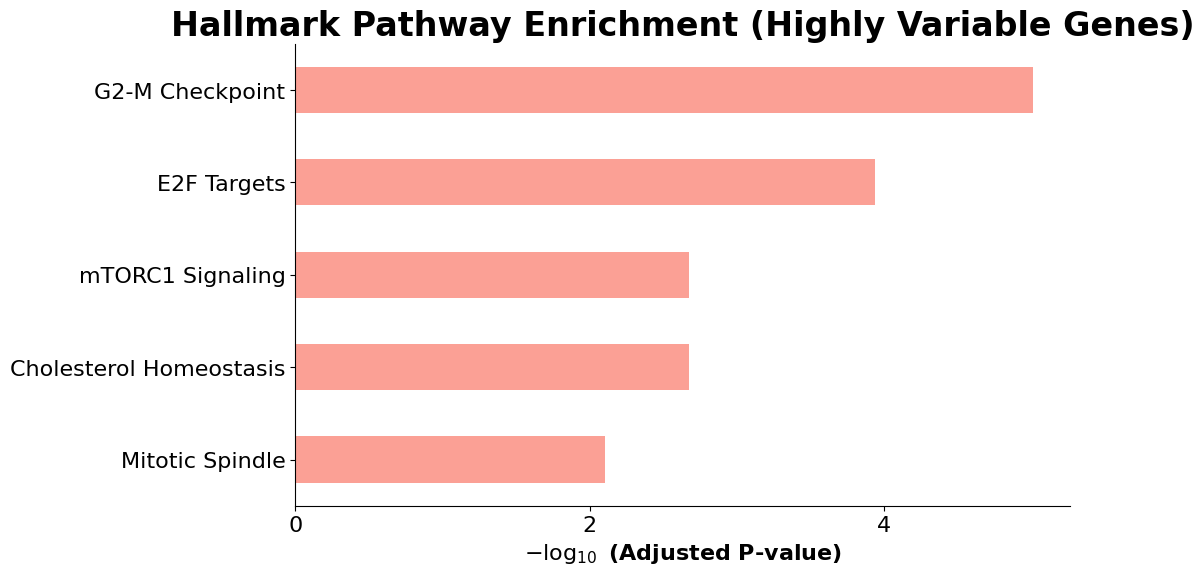

In [ ]:
print("\nRunning GSEA for MSigDB_Hallmark_2020...")
enrichment_hallmark = gp.enrichr(
    gene_list=top_variable_genes,
        gene_sets="MSigDB_Hallmark_2020",
            organism="human",
                cutoff=0.05
                )

gp.barplot(enrichment_hallmark.res2d, title="Hallmark Pathway Enrichment (Highly Variable Genes)", figsize=(10, 6))
plt.show()


Running GSEA for Drug_Perturbations_from_GEO_down...


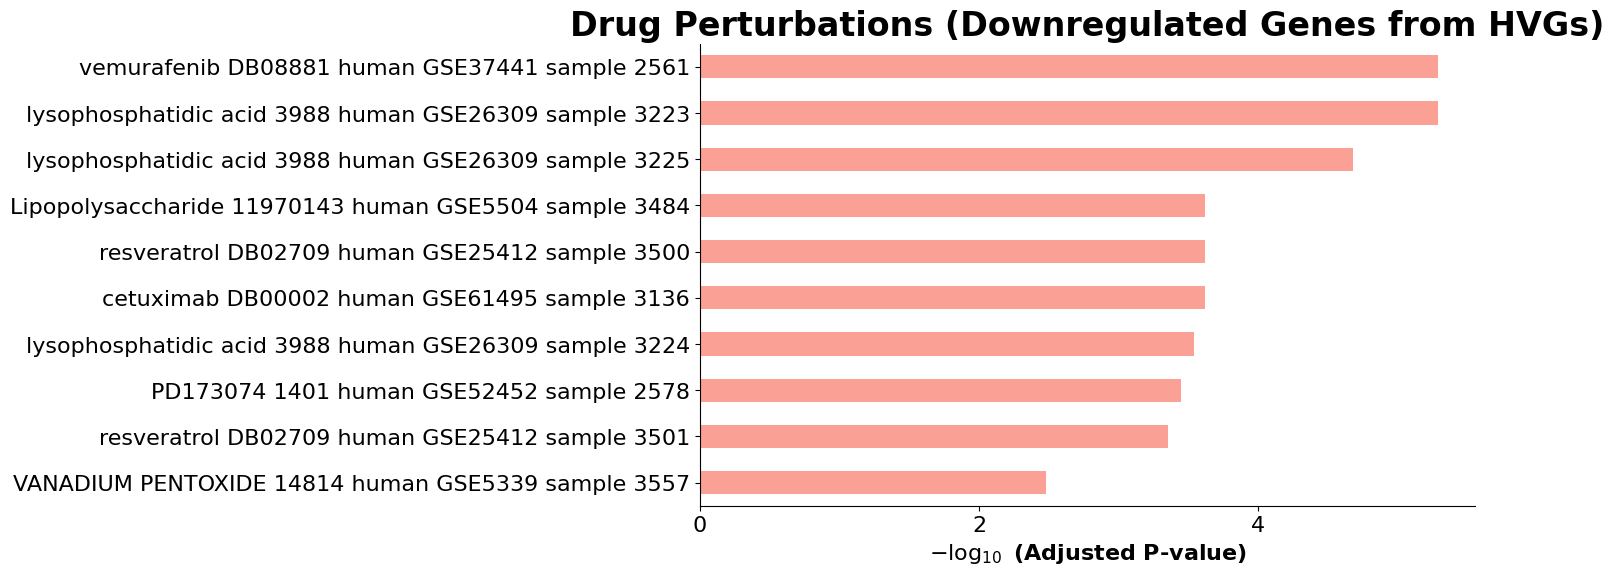

In [ ]:
print("\nRunning GSEA for Drug_Perturbations_from_GEO_down...")
enrichment_geo_down = gp.enrichr(
    gene_list=top_variable_genes,
        gene_sets="Drug_Perturbations_from_GEO_down",
            organism="human",
                cutoff=0.05
                )
gp.barplot(enrichment_geo_down.res2d.head(10), title="Drug Perturbations (Downregulated Genes from HVGs)", figsize=(10, 6))
plt.show()

In [ ]:
len(top_variable_genes)

3669

On major problem is that for the Enrichment analysis , this data has some ID related genes which are not acceptable, So I need to remove them

In [ ]:
import re

def count_numerical_digits(s):
    return sum(c.isdigit() for c in s)


    if "highly_variable" not in adata.var.columns:
        print("WARNING: 'highly_variable' column not found in adata.var. Running sc.pp.highly_variable_genes...")
        sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
        print("Highly variable genes calculated.")

initial_top_variable_genes = adata.var[adata.var["highly_variable"]].index.tolist()

print(f"\nInitial count of highly variable genes: {len(initial_top_variable_genes)}")
print(f"Sample of initial list: {initial_top_variable_genes[:15]}...")



filtered_top_variable_genes_by_digits = []

for gene in initial_top_variable_genes:
    if count_numerical_digits(gene) < 4:
      filtered_top_variable_genes_by_digits.append(gene)


Initial count of highly variable genes: 3669
Sample of initial list: ['AADAC', 'AAK1', 'AATF', 'ABCC4', 'ABCD1', 'ABCF3', 'ABHD1', 'ABHD12', 'ABHD17C', 'ABHD8', 'ABL1', 'ABRACL', 'ABRAXAS1', 'AC002044.2', 'AC002310.1']...


In [ ]:
len(filtered_top_variable_genes_by_digits)

3117


Running GSEA for KEGG_2021_Human...


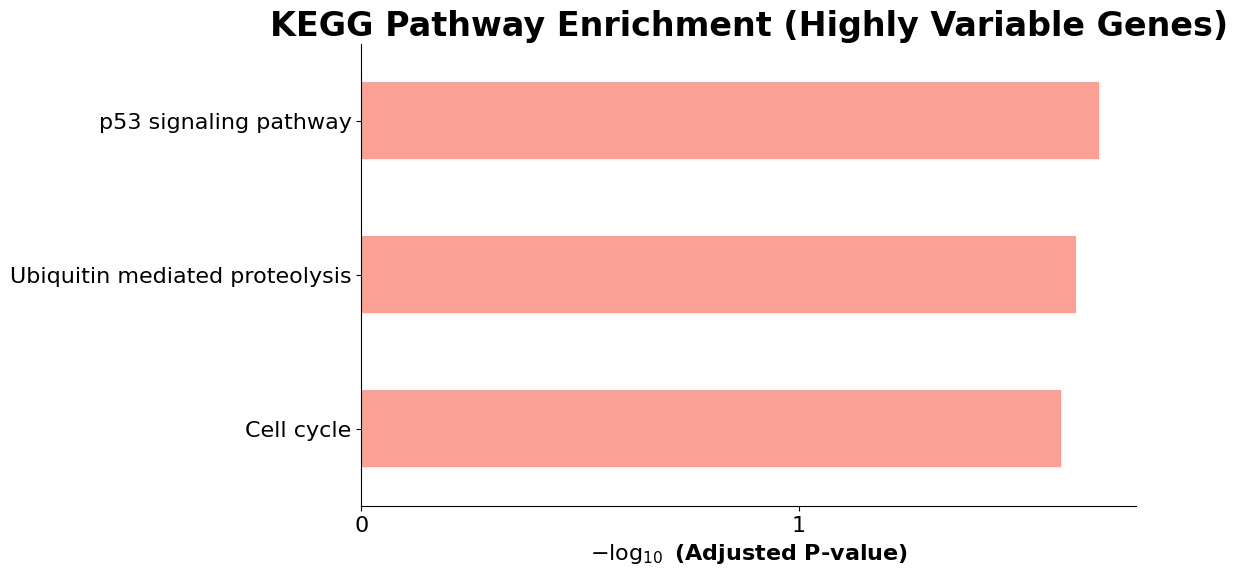

In [ ]:
print("\nRunning GSEA for KEGG_2021_Human...")
enrichment_kegg = gp.enrichr(
    gene_list=filtered_top_variable_genes_by_digits,
            gene_sets="KEGG_2021_Human",
                        organism="human",
                                        cutoff=0.50
                                                        )
gp.barplot(enrichment_kegg.res2d, title="KEGG Pathway Enrichment (Highly Variable Genes)", figsize=(10, 6))
plt.show()


Running GSEA for DisGeNET...


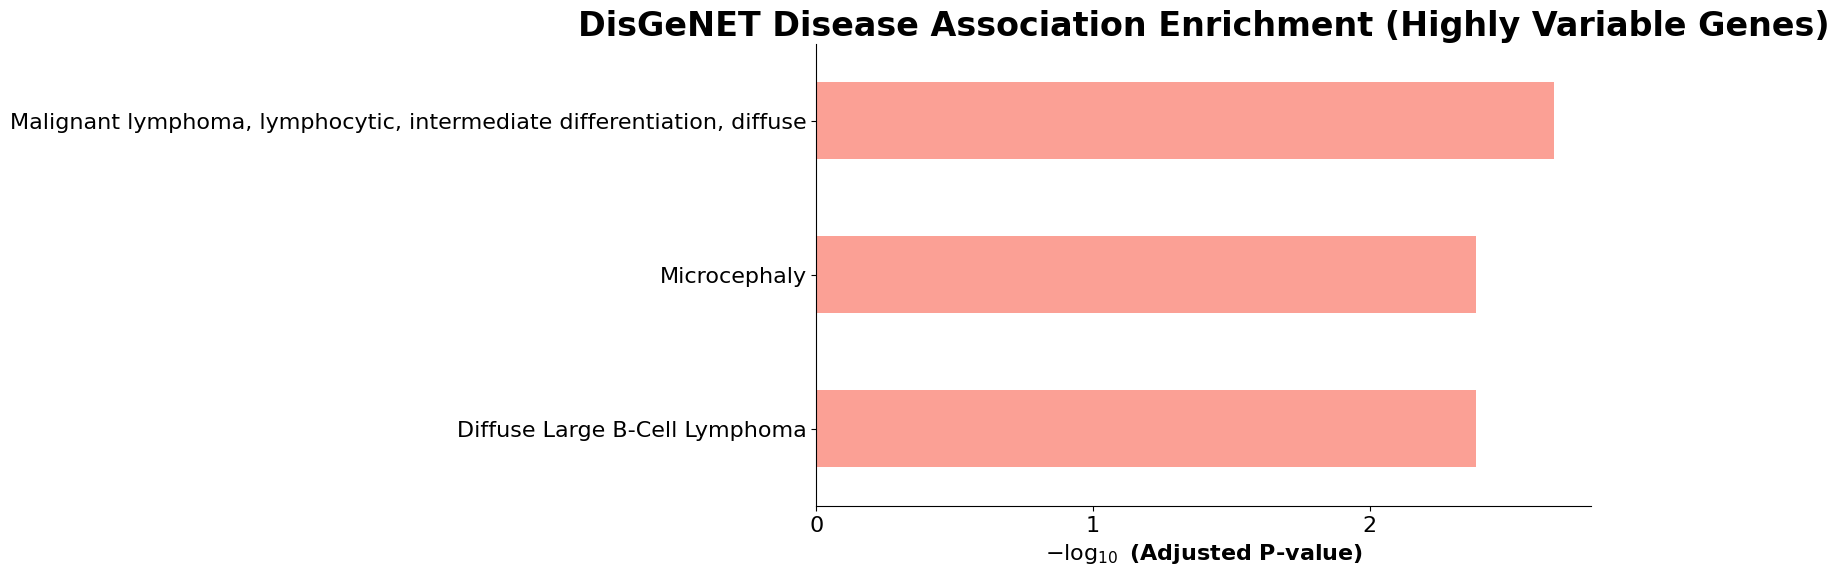

In [ ]:
print("\nRunning GSEA for DisGeNET...")
enrichment_disgenet = gp.enrichr(
    gene_list=filtered_top_variable_genes_by_digits,
            gene_sets="DisGeNET",
                        organism="human",
                                        cutoff=0.05
                                                        )
gp.barplot(enrichment_disgenet.res2d.head(10), title="DisGeNET Disease Association Enrichment (Highly Variable Genes)", figsize=(10, 6))
plt.show()